# The Causal Impact of EV Support Policies on EV Adoption

### A Propensity Score Analysis

### **[Project Summary]**
  - **Research Question:** \
  Does the implementation of electric vehicle (EV) support policies cause an increase in electric vehicle registrations in U.S. states?

  - **Goal:** \
  Estimates the causal impact of U.S. state EV support policies on EV adoption using propensity score methods, and evaluate the impact and statistical reliability through ATT and confidence intervals.

  - **Data Sources:**
    - U.S. Department of Energy's Office of Energy Efficiency and Renewable Energy - EV Policy, Registration, Stations
    - U.S. Bureau of Economic Analysis - GDP
    - U.S. Energy Information Administration - Emission (CO2)  
    - National Conference of State Legislatures - Political Leaning

      \* U.S. Census Bureau - Population

  - **Key Result:**\
  Propensity score matching shows that states with EV support policies experienced significantly higher EV registration growth than matched states without such policies, with the effect becoming statistically significant after 2020.

  - **Tech Stack:** \
  Python, Pandas, Numpy, Propensity Score(LogisticRegression, NearestNeighbors), Matplotlib, Seaborn

- **Project Outline**
  1. Data Loading & Cleaning
  2. Data Merging
  3. Exploratory Data Analysis (EDA)
  4. Propensity Score Estimation & Matching
  5. Covariate Balance Check (SMD)  
  6. Causal Effect (ATT & CI)


# Imports

Import all required libraries for data preprocessing, visulization, and Propensity Score analysis.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

# 1. Data Load & Cleaning

Load and clean 6 datasets (1 treatment, 4 confounders, and 1 outcomes) to ensure consistent structure and prepare for merging.

In [ ]:
# Treatment
laws_incentives = pd.read_csv("../data/laws_and_incentives.csv")
# Confounders
ev_station = pd.read_csv("../data/EV Stations (2016-2023).csv")
political = pd.read_csv("../data/State & Legislative Partisan Composition (2016-2023).csv")
emission = pd.read_csv("../data/Co2 per capita (2016-2023).csv")
gdp = pd.read_csv("../data/GDP.csv")
# per capita
pop1 = pd.read_csv("../data/nst-est2020.csv")
pop2 = pd.read_csv("../data/NST-EST2023-POPCHG2020_2023.csv")
# Outcome
ev = pd.read_csv("../data/EV Registration per 10000 people.csv")

## 1.1. Treatment: Law Incentives
Contains a comprehensive record of EV related incentives, laws, and regulations for each state beginning in 1990.
- It provides details on enactment, repeal, expiration, amendment, and achival date, allowing identification of whether a policy was active in a given year.
- Select titles related to light duty EV registrations and determine wheather they are active for each year and state.

In [4]:
laws_incentives.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1377 entries, 0 to 1376
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Law Id                   1377 non-null   int64  
 1   State                    1377 non-null   object 
 2   Title                    1377 non-null   object 
 3   Text                     1377 non-null   object 
 4   Enacted Date             874 non-null    object 
 5   Amended Date             227 non-null    object 
 6   Recent?                  1377 non-null   bool   
 7   Sequence Number          1293 non-null   float64
 8   Type                     1377 non-null   object 
 9   Agency                   91 non-null     object 
 10  Significant Update Date  1011 non-null   object 
 11  Expired Date             109 non-null    object 
 12  Archived Date            254 non-null    object 
 13  Repealed Date            43 non-null     object 
 14  Topic                   

In [5]:
print(f"number of columns including null: {laws_incentives.duplicated().sum()}")

number of columns including null: 0


### 1.1.1. Choosing Directly Related Titles
Selected policy titles that specifically reference EVs, alternative fuel vehicles (including EV), or related infrastructure only when EV section was explicitly mentioned.
- Titles that mentioned only infrastructure were excluded.
- Titles referring soley to fueling and charging infrastructure were excluded.
- 49 titles were selected out of 1093 total titles.

In [6]:
related = [
    "Electric Vehicle (EV) Grants",
    "Electric Vehicle (EV) Incentive",
    "Low-Income Electric Vehicle (EV) Rebates  ",
    "Electric Vehicle (EV) Rebate",
    "Electric Vehicle (EV) Rebate Program",
    "Electric Vehicle (EV) Rebates",
    "Zero Emission Vehicle (ZEV) Tax Credit",
    "Plug-in Electric Vehicle (PEV) Rebate",
    "Electric Vehicle (EV) Tax Credit",
    "All-Electric Vehicle (EV) Registration Fee Reduction",
    "Electric Vehicle (EV) Title Excise Tax Exemption",
    "Pre-Owned Electric Vehicle (EV) and Fuel Cell Electric Vehicle (FCEV) Tax Credit",
    "Electric Vehicle (EV) Promotion and Infrastructure Development",
    "Hybrid Electric Vehicle (HEV) and Electric Vehicle (EV) Tax Credit",
    "Electric Vehicle (EV) and Fuel Cell Electric Vehicle (FCEV) Tax Credit",
    "Electric Vehicle (EV) and Hydrogen Fuel Cell Electric Vehicle (FCEV) Tax Credit",
    "Alternative Fuel Vehicle (AFV) Incentives",
    "Alternative Fuels Incentive Grant (AFIG) Program",
    "Plug-In Hybrid and Zero Emission Light-Duty Vehicle Rebates",
    "Plug-In Hybrid Electric Vehicle (PHEV) and Zero Emission Vehicle Rebates",
    "Zero Emission Vehicle (ZEV) Rebate Program Authorization",
    "Electric Vehicle (EV) and Plug-In Hybrid Electric Vehicle (PHEV) Rebates",
    "Electric Vehicle (EV) and Infrastructure Grants",
    "Light-Duty Zero Emission Vehicle (ZEV) Rebates",
    "Pre-Owned Light-Duty Zero Emission Vehicle (ZEV) Rebates",
    "Hydrogen Fuel Cell Electric Vehicle (FCEV) and Electric Vehicle (EV) Rebate",
    "Municipal Zero Emission Vehicle (ZEV) and Infrastructure Rebates",
    "Alternative Fuel Vehicle (AFV) Rebate Program",
    "Hybrid Electric Vehicle Rebate",
    "Alternative Fuel Vehicle (AFV) Rebate",
    "Alternative Fuel Tax Exemption for Electric Vehicles (EVs)",
    "Zero Emissions Vehicle (ZEV) Tax Exemption",
    "Alternative Fuel Vehicle (AFV) Tax Exemption",
    "Alternative Fuel Tax Exemption",
    "Alternative Fuel Vehicle (AFV) and Hybrid Electric Vehicle (HEV) Tax Exemption",
    "Alternative Fuel and Alternative Fuel Vehicle (AFV) Use Tax Exemption",
    "Reduced Alternative Fuel Vehicle (AFV) License Tax",
    "Alternative Fuel Vehicle (AFV) Tax Credit",
    "Alternative Fuel Vehicle (AFV) Conversion Tax Credit",
    "Alternative Fuel Vehicle (AFV) Tax Deduction",
    "Alternative Fuel Vehicle (AFV) Voucher Program",
    "Alternative Fuel Vehicle (AFV) Loans",
    "Alternative Fuel Vehicle (AFV) Loan Program",
    "Alternative Fuel Vehicle (AFV) Revolving Loan Program for Private Entities",
    "Alternative Fuel Vehicle (AFV) Revolving Loan Program for Public Entities",
    "Zero Emission Vehicle (ZEV) and Plug-In Hybrid Electric Vehicle (PHEV) Rebates",
    "Alternative Fuel and Vehicle Incentives",
    "Alternative Fuel Vehicle (AFV) Registration",
    "Plug-in Electric Vehicle (PEV) Promotion"
]

### 1.1.2. Final Law Incentives Data
Created a DataFrame indicating whether any selected policy titles are active for each state and year.
  -  If at least one selected title is active in a given year, the state is marked as 1. Otherwise, it is marked as 0.

In [7]:
related_df = laws_incentives[laws_incentives["Title"].isin(related)].copy()

for col in ["Enacted Date", "Expired Date", "Archived Date", "Repealed Date"]:
  related_df[col] = pd.to_datetime(related_df[col], utc= True, errors='coerce')

In [8]:
def active_policy(row, year):
  start_year = pd.Timestamp(f"{year}-01-01", tz = "UTC")
  end_year = pd.Timestamp(f"{year}-12-31", tz = "UTC")

  enacted = row["Enacted Date"]
  date_end = [row["Expired Date"], row["Archived Date"], row["Repealed Date"]]

  if pd.isna(enacted):
    return 0
  valid_end = [e for e in date_end if pd.notna(e)]
  policy_end = min(valid_end) if valid_end else end_year

  if enacted <= end_year and policy_end >= start_year:
    return 1
  else:
    return 0

In [9]:
years = list(range(2016, 2024))
states = laws_incentives['State'].unique()

for y in years:
  related_df[f"policy_{y}"] = related_df.apply(lambda r: active_policy(r, y), axis = 1)

p_col = [f"policy_{y}" for y in years]
policy = related_df.groupby("State")[p_col].max().reset_index()
policy_df = pd.DataFrame({'State':states})
policy_df = policy_df.merge(policy, on="State", how='left').fillna(0)

policy_df[p_col] = policy_df[p_col].astype(int)

In [10]:
policy_df = policy_df[~policy_df["State"].isin(["DC", "US"])]
state_map = {
    "AL": "Alabama", "AK": "Alaska", "AZ": "Arizona", "AR": "Arkansas", "CA": "California",
    "CO": "Colorado", "CT": "Connecticut", "DE": "Delaware",
    "FL": "Florida", "GA": "Georgia", "HI": "Hawaii", "ID": "Idaho", "IL": "Illinois",
    "IN": "Indiana", "IA": "Iowa", "KS": "Kansas", "KY": "Kentucky", "LA": "Louisiana",
    "ME": "Maine", "MD": "Maryland", "MA": "Massachusetts", "MI": "Michigan",
    "MN": "Minnesota", "MS": "Mississippi", "MO": "Missouri", "MT": "Montana",
    "NE": "Nebraska", "NV": "Nevada", "NH": "New Hampshire", "NJ": "New Jersey",
    "NM": "New Mexico", "NY": "New York", "NC": "North Carolina", "ND": "North Dakota",
    "OH": "Ohio", "OK": "Oklahoma", "OR": "Oregon", "PA": "Pennsylvania",
    "RI": "Rhode Island", "SC": "South Carolina", "SD": "South Dakota",
    "TN": "Tennessee", "TX": "Texas", "UT": "Utah", "VT": "Vermont", "VA": "Virginia",
    "WA": "Washington", "WV": "West Virginia", "WI": "Wisconsin", "WY": "Wyoming"
}
policy_df["State"] = policy_df["State"].map(state_map)
policy_df = policy_df.sort_values("State").reset_index().drop(columns=["index"])

In [11]:
policy_df.head()

,State,policy_2016,policy_2017,policy_2018,policy_2019,policy_2020,policy_2021,policy_2022,policy_2023
0,Alabama,0,0,0,0,0,0,0,0
1,Alaska,0,0,0,0,0,0,0,0
2,Arizona,0,0,1,1,1,1,1,1
3,Arkansas,0,0,0,0,0,0,0,0
4,California,1,1,1,1,1,1,1,1


## 1.2. Confounders: Charging stations, Political Leaning, $CO_2$ Emmission,  GDP
Confounders: Features that affect both the treatment and the outcome, which may bias the estimated effect if not controlled.
- Infrastructure: EV Station
- Social: Political Leaning
- Environment: $CO_2$ Emission
- Economic: GDP

### 1.2.1 EV Station
Number of EV Charging Stations for each state and year.
- The availability of charging stations is a key factor influencing individuals' decisions to purchase EVs.
- A higher number of stations may also encourage the adoption of EV supportive policies.

In [12]:
ev_station.head()

,State,EV_Station_2016,EV_Station_2017,EV_Station_2018,EV_Station_2019,EV_Station_2020,EV_Station_2021,EV_Station_2022,EV_Station_2023
0,Alabama,113,145,165,195,224,277,327,424
1,Alaska,3,7,7,19,37,52,61,65
2,Arizona,424,432,480,522,573,890,984,"1,198"
3,Arkansas,63,62,70,98,112,164,218,334
4,California,"4,184","4,683","5,480","6,439","7,689","14,607","14,609","16,381"


In [13]:
for col in ev_station.columns:
  if col != "State":
    ev_station[col] = ev_station[col].str.replace(',','').astype(int)

In [14]:
ev_station.describe()

,EV_Station_2016,EV_Station_2017,EV_Station_2018,EV_Station_2019,EV_Station_2020,EV_Station_2021,EV_Station_2022,EV_Station_2023
count,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,348.666667,390.980392,447.941176,528.784314,622.568627,982.294118,1050.352941,1261.078431
std,602.568790,674.372108,787.101300,930.450994,1109.494592,2068.491511,2082.044186,2348.425241
min,3.000000,7.000000,7.000000,19.000000,37.000000,52.000000,61.000000,65.000000
25%,71.000000,81.000000,89.000000,110.000000,136.000000,185.500000,216.000000,297.500000
50%,197.000000,229.000000,226.000000,286.000000,309.000000,451.000000,470.000000,565.000000
75%,436.500000,508.500000,592.500000,639.500000,751.000000,1063.000000,1193.500000,1504.500000
max,4184.000000,4683.000000,5480.000000,6439.000000,7689.000000,14607.000000,14609.000000,16381.000000


### 1.2.2. Political Leaning
Used state control, determined based on the legislative control and governor's party.
- If legislative control and governor's party differ, the state is classified as "Divided".
- The dominant political party strongly affects policy decisions, including the likelihood of adopting EV supportive policies.
- States that tend to prioritize environmental issues also show higher EV adoption, independent of policy.

In [15]:
political.head()

,State,Political_2016,Political_2017,Political_2018,Political_2019,Political_2020,Political_2021,Political_2022,Political_2023
0,Alabama,Rep,Rep,Rep,Rep,Rep,Rep,Rep,Rep
1,Alaska,Divided,Divided,Divided,Rep,Rep,Rep,Rep,Rep
2,Arizona,Rep,Rep,Rep,Rep,Rep,Rep,Rep,Divided
3,Arkansas,Rep,Rep,Rep,Rep,Rep,Rep,Rep,Rep
4,California,Dem,Dem,Dem,Dem,Dem,Dem,Dem,Dem


### 1.2.3. $CO_2$ Emission
Includes per capita $CO_2$ emissions measured in metrics tons of $CO_2$
- States with a greater concern about emssions may have stronger environmental regulations, making them more likely to adopt EV supportive policies.
- Higher environmental awareness can encourage individuals to purchase EVs independent of policy.

In [16]:
emission.head()

,State,co2_2016,co2_2017,co2_2018,co2_2019,co2_2020,co2_2021,co2_2022,co2_2023
0,Alabama,45.0,45.5,46.9,46.8,49.2,54.2,57.4,58.6
1,Alaska,23.3,22.2,22.9,21.6,19.5,21.5,21.6,19.7
2,Arizona,20.7,21.3,23.4,21.5,18.1,20.4,20.8,19.7
3,Arkansas,13.1,12.8,13.1,12.7,11.1,11.4,10.9,11.1
4,California,8.9,9.0,9.0,9.0,7.6,8.2,8.3,8.3


In [17]:
emission.describe()

,co2_2016,co2_2017,co2_2018,co2_2019,co2_2020,co2_2021,co2_2022,co2_2023
count,50.000000,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000
mean,20.810000,20.676000,21.222000,20.536000,18.55400,19.600000,19.736000,18.942000
std,16.920743,17.458587,17.829548,16.752883,16.20062,16.370095,16.718385,16.029591
min,8.600000,8.400000,8.900000,8.600000,7.10000,7.900000,8.200000,7.800000
25%,11.875000,11.325000,11.425000,11.225000,9.95000,10.475000,10.725000,10.350000
50%,15.950000,15.800000,16.450000,15.900000,13.50000,14.500000,14.750000,13.950000
75%,23.200000,23.100000,23.275000,22.650000,20.77500,21.575000,21.900000,20.800000
max,104.600000,108.200000,110.200000,101.700000,96.10000,94.000000,96.700000,92.900000


### 1.2.4. Gross Domestic Product (GDP)
Includes state GDP in millions of dollars for each year.
- States with higher income levels may have more financial capacity and public support to enact EV supportive policies.
- Higher income increases individuals' ability to purchase EVs, leading to higher EV registration independent of policy.

In [18]:
gdp = gdp.rename(columns={"GeoName":"State"})
gdp = gdp.rename(columns={col: f"gdp_{col}" for col in gdp.columns if col.isdigit()})
gdp = gdp[["State","gdp_2016","gdp_2017","gdp_2018","gdp_2019","gdp_2020","gdp_2021","gdp_2022","gdp_2023"]]

In [19]:
gdp.head()

,State,gdp_2016,gdp_2017,gdp_2018,gdp_2019,gdp_2020,gdp_2021,gdp_2022,gdp_2023
0,United States,18804913.0,19612102.0,20656516.0,21539982.0,21354105.0,23681171.0,26006893.0,27720709.0
1,Alabama,208824.3,216615.5,226263.8,234798.2,235325.3,260018.4,284949.1,304935.6
2,Alaska,51121.8,53550.9,54762.0,54549.6,51283.4,58943.5,66271.9,68056.0
3,Arizona,313787.1,333099.0,353671.0,375376.7,388956.7,436778.6,484052.2,522767.2
4,Arkansas,120987.4,123882.6,129213.8,132625.8,136198.4,154052.5,168605.8,178606.4


In [20]:
gdp.describe()

,gdp_2016,gdp_2017,gdp_2018,gdp_2019,gdp_2020,gdp_2021,gdp_2022,gdp_2023
count,6.000000e+01,6.000000e+01,6.000000e+01,6.000000e+01,6.000000e+01,6.000000e+01,6.000000e+01,6.000000e+01
mean,9.367676e+05,9.771223e+05,1.028803e+06,1.072800e+06,1.063378e+06,1.179624e+06,1.295420e+06,1.380922e+06
std,2.517294e+06,2.626492e+06,2.766671e+06,2.886095e+06,2.861727e+06,3.174083e+06,3.484191e+06,3.713716e+06
min,3.184020e+04,3.258920e+04,3.348260e+04,3.476030e+04,3.441490e+04,3.743880e+04,4.101160e+04,4.353380e+04
25%,1.164912e+05,1.199853e+05,1.242574e+05,1.285033e+05,1.305394e+05,1.456132e+05,1.600169e+05,1.701630e+05
50%,3.089652e+05,3.165803e+05,3.277979e+05,3.408284e+05,3.392787e+05,3.676610e+05,4.004432e+05,4.292808e+05
75%,6.307328e+05,6.594682e+05,6.870470e+05,7.212687e+05,7.137630e+05,7.838048e+05,8.544308e+05,9.077158e+05
max,1.880491e+07,1.961210e+07,2.065652e+07,2.153998e+07,2.135410e+07,2.368117e+07,2.600689e+07,2.772071e+07


## 1.3. Outcome: EV Registrations Growth
Includes the number of light duty EV registrations growth per 10,000 people by year and state.
- Light duty EV refer to personal or light commercial vehicle such as cars, SUVs, and small trucks.
- Calculate annual EV growth as the difference in registrations between the current and previous year to more clearly analyze the impact of EV supprotive policies on EV adoption.

In [21]:
for y in range(2017, 2024):
  ev[f"EV_growth_{y}"] = ev[f"EV_{y}"] - ev[f"EV_{y-1}"]

In [22]:
drop = [f"EV_{y}" for y in range(2016, 2024)]
ev = ev.drop(columns=drop)

In [23]:
ev.head()

,State,EV_growth_2017,EV_growth_2018,EV_growth_2019,EV_growth_2020,EV_growth_2021,EV_growth_2022,EV_growth_2023
0,Alabama,1,1,1,2,3,8,8
1,Alaska,2,2,3,2,6,9,10
2,Arizona,3,8,9,13,16,33,32
3,Arkansas,0,1,1,1,4,9,6
4,California,12,21,20,19,36,88,90


In [24]:
ev.describe()

,EV_growth_2017,EV_growth_2018,EV_growth_2019,EV_growth_2020,EV_growth_2021,EV_growth_2022,EV_growth_2023
count,50.000000,50.00000,50.000000,50.000000,50.0000,50.000000,50.000000
mean,1.900000,4.02000,4.640000,4.940000,9.7600,20.800000,23.080000
std,2.484647,3.70598,4.144138,3.893532,6.9475,15.444436,16.949914
min,-3.000000,0.00000,0.000000,0.000000,1.0000,3.000000,4.000000
25%,1.000000,1.25000,2.000000,2.000000,5.0000,11.000000,12.000000
50%,1.000000,3.00000,3.000000,4.000000,8.0000,16.000000,17.000000
75%,2.000000,6.00000,5.750000,6.750000,12.7500,28.500000,32.000000
max,12.000000,21.00000,20.000000,19.000000,36.0000,88.000000,90.000000


# 2. Merge Data
Merged the treatment, confounder and outcome datasets by state to prepare the final dataset for the propensity score analysis.
- Adjusting for State Population Size
  - Convert GDP (in millions of dollars) to GDP per capita, and convert the number of charging stations to stations per 100,000 people.
  - Using population based measures improves comparability across states and reduces the confounding effect of population size.

In [25]:
pop1 = pop1[["NAME", "POPESTIMATE2016", "POPESTIMATE2017", "POPESTIMATE2018", "POPESTIMATE2019"]]
pop2 = pop2[["NAME", "POPESTIMATE2020", "POPESTIMATE2021",	"POPESTIMATE2022", "POPESTIMATE2023"]]
pop1 = pop1.rename(columns={"NAME": "State"})
pop2 = pop2.rename(columns={"NAME": "State"})

In [26]:
merged_df = policy_df.copy()

merge = [ev_station, political, emission, gdp, pop1, pop2, ev]
for m in merge:
  merged_df = pd.merge(merged_df, m, how='left',on="State")

In [27]:
for y in range(2016,2024):
  merged_df[f"EV_Station_{y}"] = (merged_df[f"EV_Station_{y}"] / merged_df[f"POPESTIMATE{y}"]) * 100000
  merged_df[f"gdp_{y}"] = (merged_df[f"gdp_{y}"] * 1000000) / merged_df[f"POPESTIMATE{y}"]

In [28]:
drop = [f"POPESTIMATE{y}" for y in range(2016, 2024)]
merged_df = merged_df.drop(columns=drop)

In [29]:
merged_df.head()

,State,policy_2016,policy_2017,policy_2018,policy_2019,policy_2020,policy_2021,policy_2022,policy_2023,EV_Station_2016,...,gdp_2021,gdp_2022,gdp_2023,EV_growth_2017,EV_growth_2018,EV_growth_2019,EV_growth_2020,EV_growth_2021,EV_growth_2022,EV_growth_2023
0,Alabama,0,0,0,0,0,0,0,0,2.321843,...,51484.917967,56159.745269,59692.181687,1,1,1,2,3,8,8
1,Alaska,0,0,0,0,0,0,0,0,0.404000,...,80203.640381,90377.838631,92794.441278,2,2,3,2,6,9,10
2,Arizona,0,0,1,1,1,1,1,1,6.105316,...,60059.041701,65717.209698,70346.252306,3,8,9,13,16,33,32
3,Arkansas,0,0,0,0,0,0,0,0,2.105745,...,50868.548624,55345.843821,58220.991925,0,1,1,1,4,9,6
4,California,1,1,1,1,1,1,1,1,10.687323,...,87468.464731,93759.168657,99329.134595,12,21,20,19,36,88,90


In [30]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 48 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   State            50 non-null     object 
 1   policy_2016      50 non-null     int64  
 2   policy_2017      50 non-null     int64  
 3   policy_2018      50 non-null     int64  
 4   policy_2019      50 non-null     int64  
 5   policy_2020      50 non-null     int64  
 6   policy_2021      50 non-null     int64  
 7   policy_2022      50 non-null     int64  
 8   policy_2023      50 non-null     int64  
 9   EV_Station_2016  50 non-null     float64
 10  EV_Station_2017  50 non-null     float64
 11  EV_Station_2018  50 non-null     float64
 12  EV_Station_2019  50 non-null     float64
 13  EV_Station_2020  50 non-null     float64
 14  EV_Station_2021  50 non-null     float64
 15  EV_Station_2022  50 non-null     float64
 16  EV_Station_2023  50 non-null     float64
 17  Political_2016   5

# 3. Exploratory Data Analysis (EDA)
- Compared States with active EV supportive policies (treatment) and those without (control).
- Examined correlations among confounders to assess multicollinearity.

## 3.1. Compare Treatment Vs. Control States
Observed differences in confounders between treatment and control states.

Overall, significant differences were observed, which should be addressed before assessing the actual treatment (policy) effect.

### 3.1.1. EV Station per 100,000 people

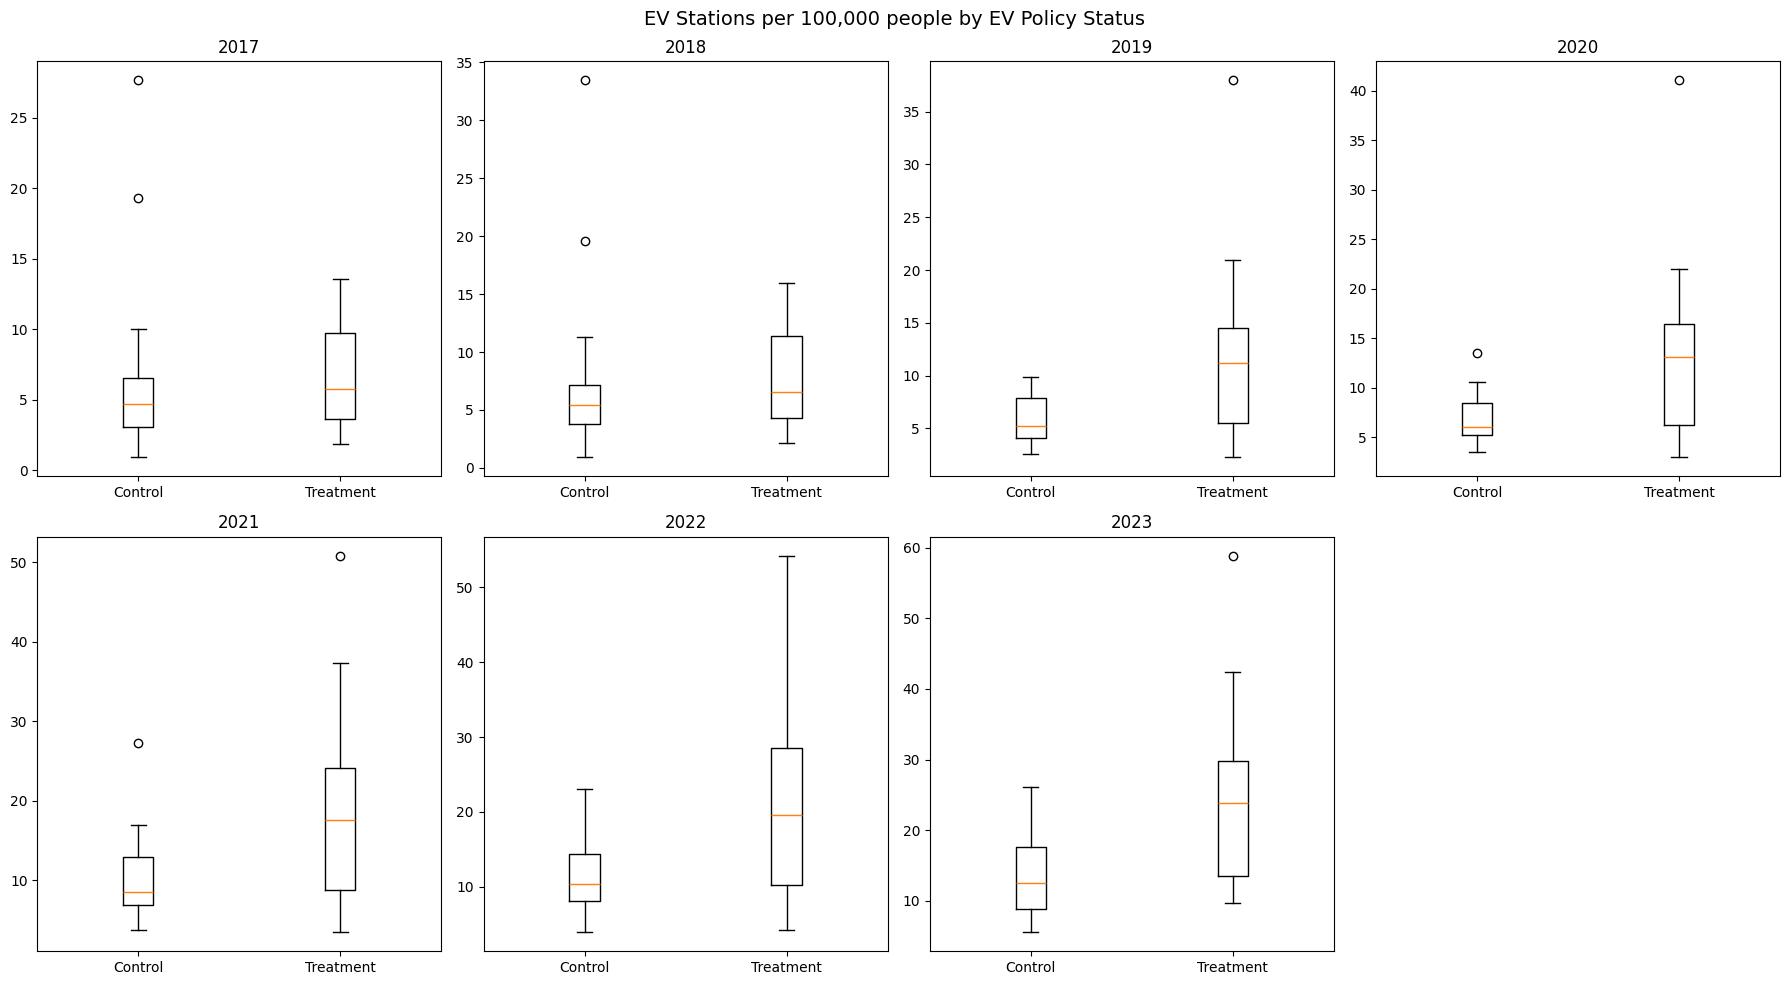

In [31]:
years = range(2017, 2024)

fig, axes = plt.subplots(2, 4, figsize=(18,10))
axes = axes.flatten()

for i, y in enumerate(years):
  axes[i].boxplot([merged_df[(merged_df[f"policy_{y}"]==0)][f'EV_Station_{y}'], merged_df[merged_df[f"policy_{y}"]==1][f'EV_Station_{y}']])
  axes[i].set_title(y)
  axes[i].set_xticklabels(["Control", "Treatment"])

fig.delaxes(axes[7])
fig.suptitle("EV Stations per 100,000 people by EV Policy Status", fontsize=14)
plt.tight_layout()
plt.show()

**[Observation]**
- The number of EV charging stations increased faster in states with EV supportive policies.
- Both the median and upper values are higher in the treatment group, indicating that states with EV supportive policies tend to have better charging infrastructure.



### 3.1.2. Political Leaning

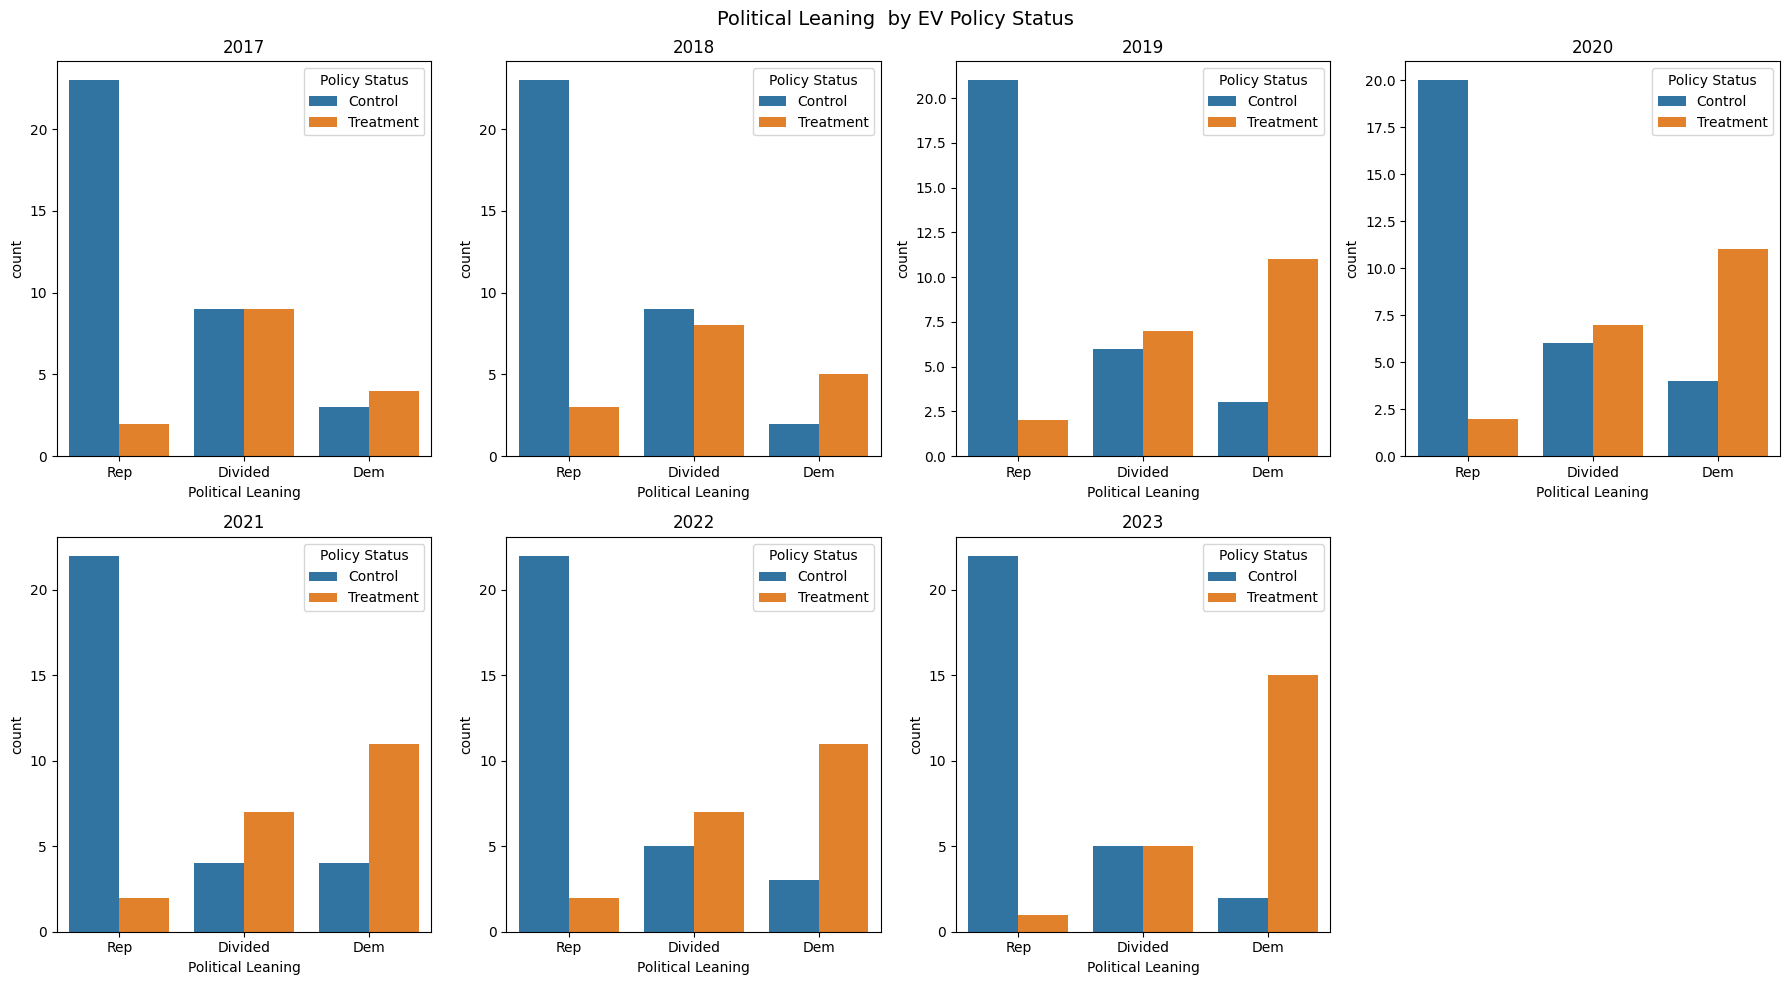

In [32]:
years = range(2017, 2024)

fig, axes = plt.subplots(2, 4, figsize=(18,10))
axes = axes.flatten()

for i, y in enumerate(years):
  sns.countplot(data = merged_df, x=f"Political_{y}", hue=f"policy_{y}",ax=axes[i], order=["Rep","Divided", "Dem"])
  axes[i].set_title(y)
  axes[i].legend(title="Policy Status", labels = ["Control", "Treatment"])
  axes[i].set_xlabel("Political Leaning")

fig.delaxes(axes[7])
fig.suptitle("Political Leaning  by EV Policy Status", fontsize=14)
plt.tight_layout()
plt.show()

**[Observation]**
- States with active EV supportive policies are more often Democratic or Divided.
- Over time, treatment states show a trend of becoming increasingly Democratic.

### 3.1.3. $CO_2$ per capita

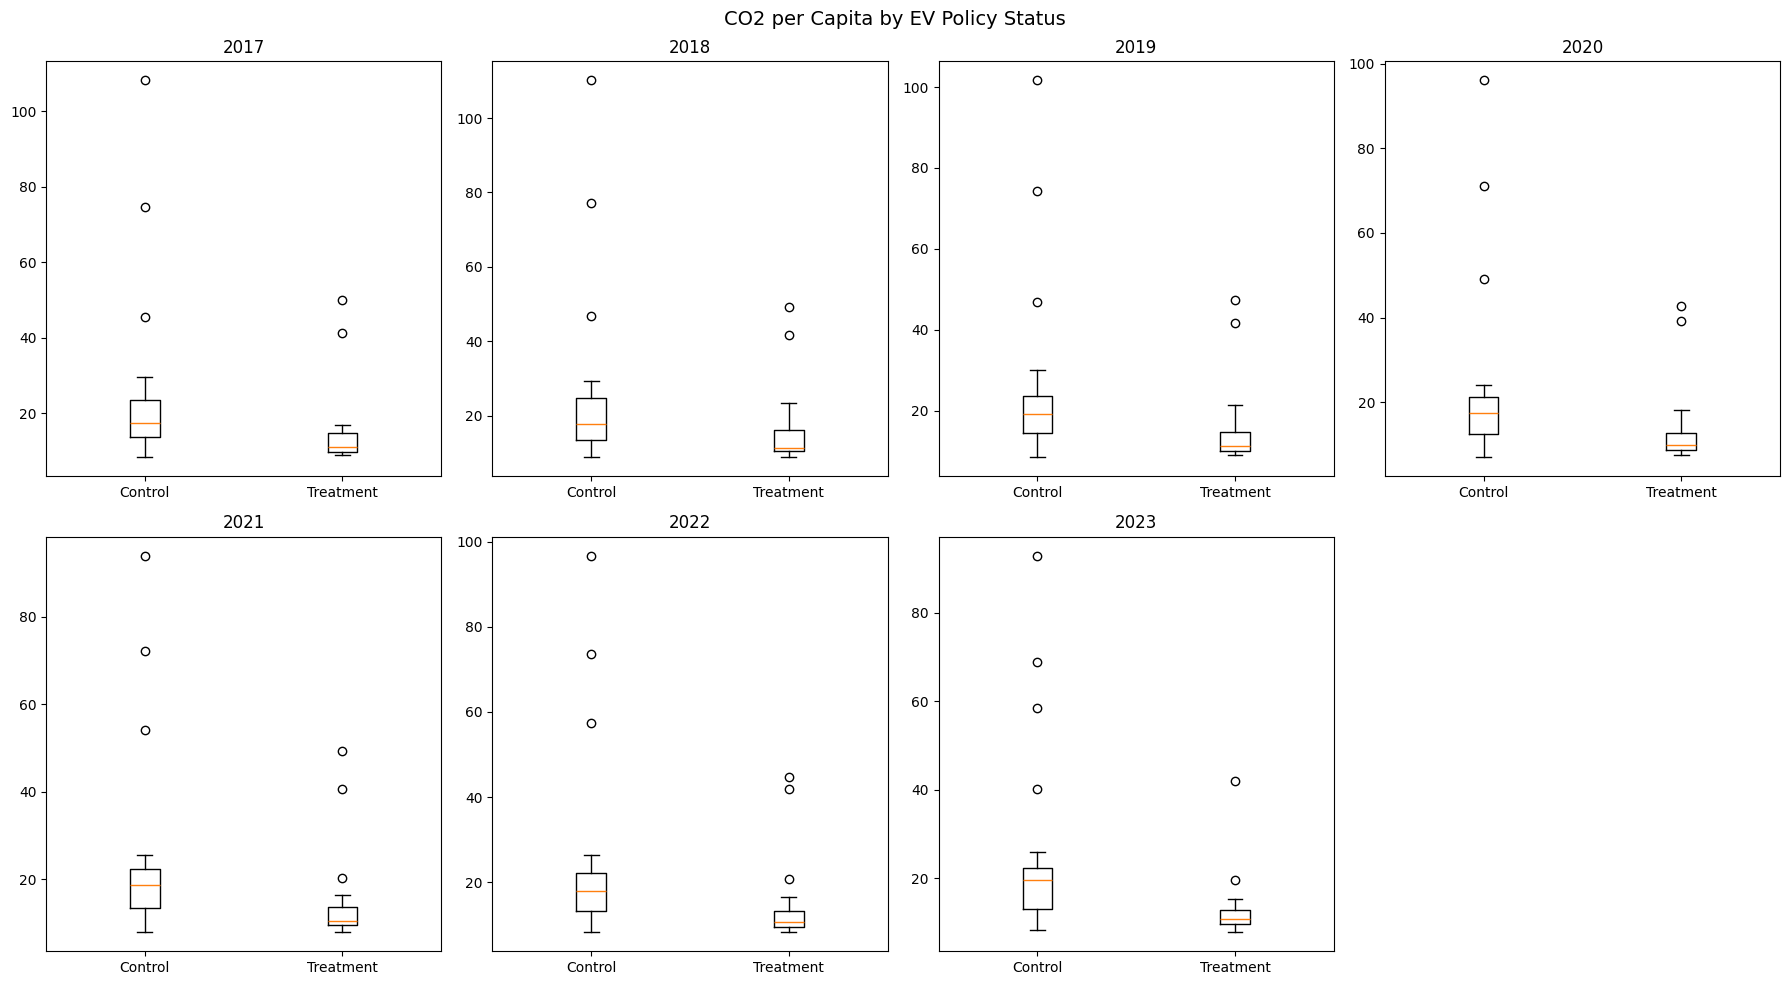

In [33]:
years = range(2017, 2024)

fig, axes = plt.subplots(2, 4, figsize=(18,10))
axes = axes.flatten()

for i, y in enumerate(years):
  axes[i].boxplot([merged_df[merged_df[f"policy_{y}"]==0][f'co2_{y}'], merged_df[merged_df[f"policy_{y}"]==1][f'co2_{y}']])
  axes[i].set_title(y)
  axes[i].set_xticklabels(["Control", "Treatment"])

fig.delaxes(axes[7])
fig.suptitle("CO2 per Capita by EV Policy Status", fontsize=14)
plt.tight_layout()
plt.show()

**[Observation]**
- States with active EV supportive policies tend to have lower $CO_2$ emissions per capita than those without such policies.
- Treatment states show a lower median and less variation, while control states show wider dispersion, with some states having high emission levels.

### 3.1.4. GPD per capita

In [34]:
# Find the outlier in control group (One with the highest gdp)
merged_df.sort_values("gdp_2017", ascending= False).iloc[0]['State']

'New York'

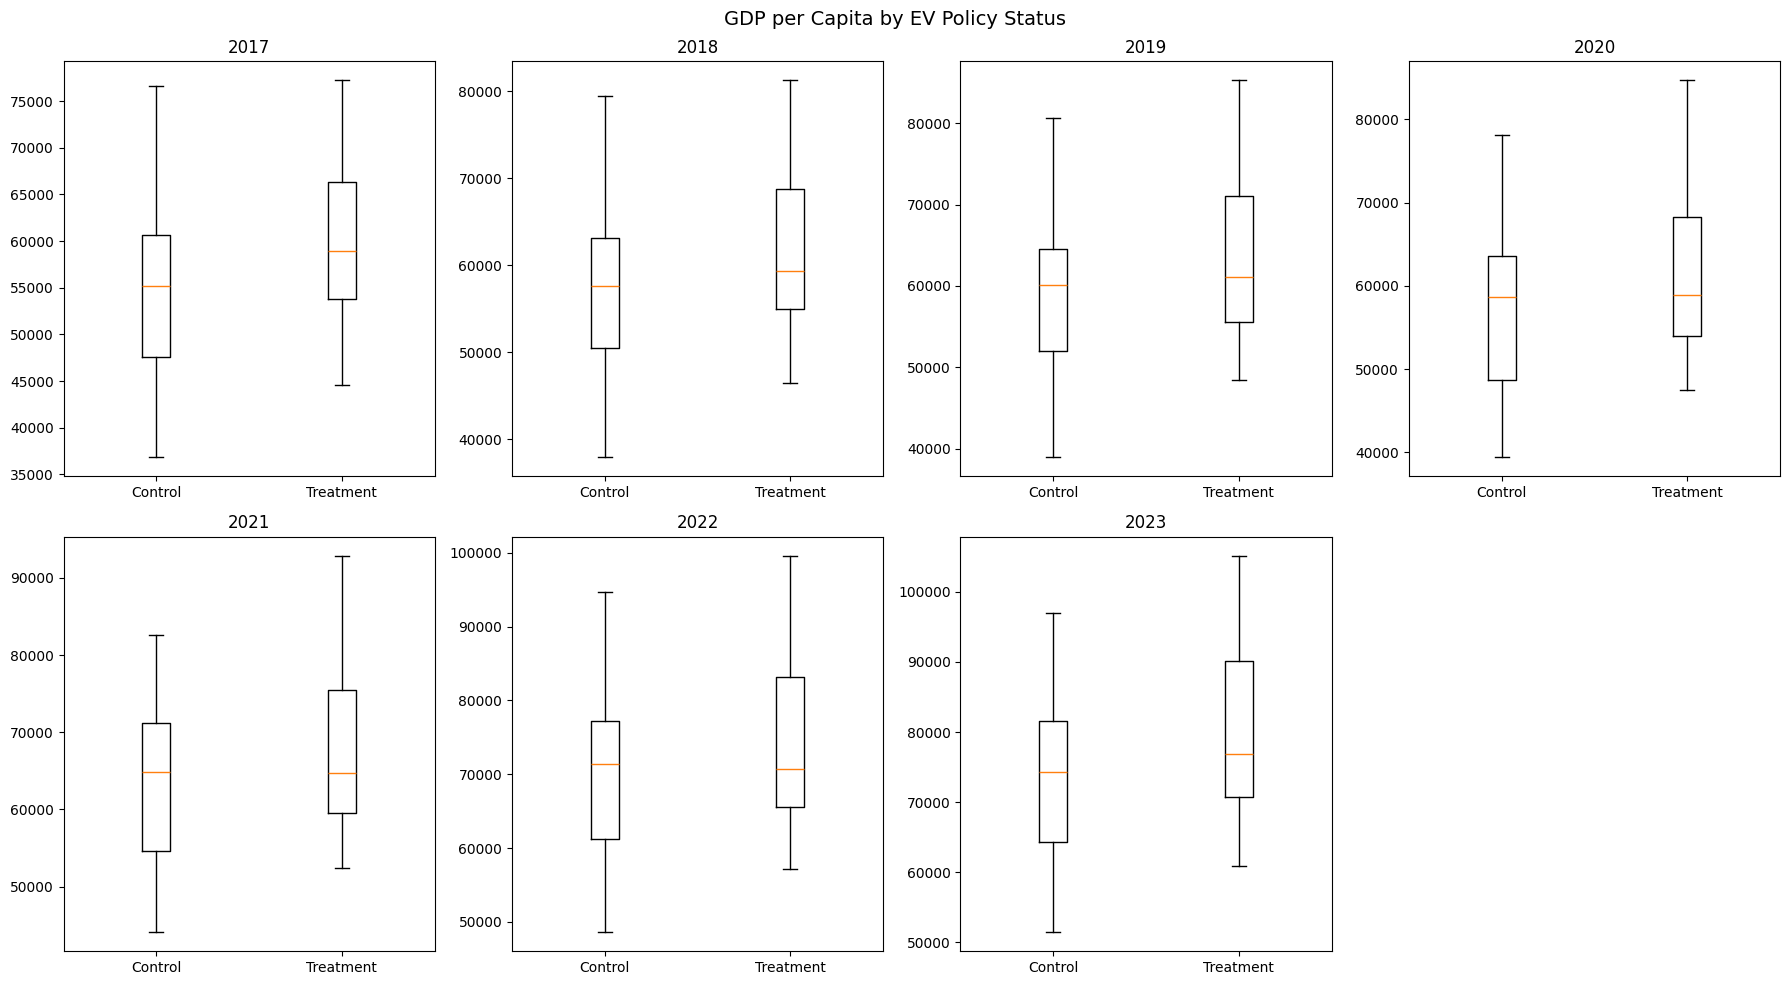

In [35]:
years = range(2017, 2024)

fig, axes = plt.subplots(2, 4, figsize=(18,10))
axes = axes.flatten()

for i, y in enumerate(years):
  axes[i].boxplot([merged_df[(merged_df["State"]!="New York") & (merged_df[f"policy_{y}"]==0)][f'gdp_{y}'], merged_df[merged_df[f"policy_{y}"]==1][f'gdp_{y}']])
  axes[i].set_title(y)
  axes[i].set_xticklabels(["Control", "Treatment"])

fig.delaxes(axes[7])
fig.suptitle("GDP per Capita by EV Policy Status", fontsize=14)
plt.tight_layout()
plt.show()

**[Observation]**
- States with active EV policies generally show similar or higher GDP per capita acroos the median, lower, and upper ranges compared to states without such policies.




## 3.2. Confounders Correlation Matrix
- Since correlations between features are unlikely to change significantly over time, only 2017, 2020, and 2023 were examined.  
- Political Leaning was included through one hot encoding.


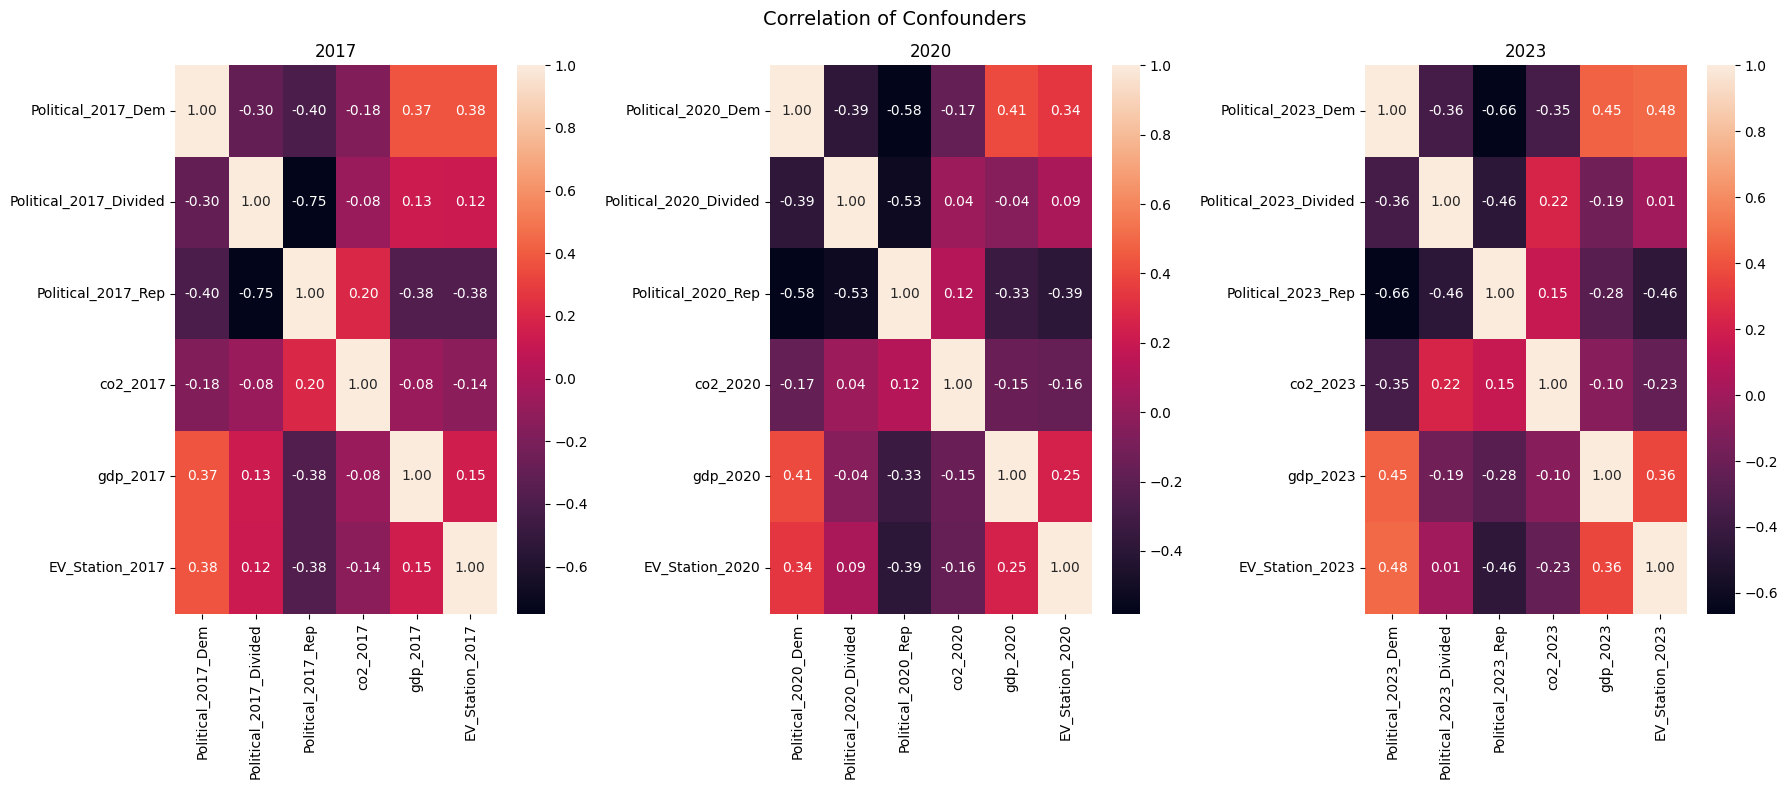

In [36]:
years = [2017,2020,2023]

fig, axes = plt.subplots(1, 3, figsize=(18,8))
axes = axes.flatten()

for i,y in enumerate(years):
  pol = f"Political_{y}"
  pol_dummy = pd.get_dummies(merged_df[pol], prefix=pol)
  confounder = merged_df[[f"co2_{y}",f"gdp_{y}",f"EV_Station_{y}"]].copy()
  confounder = pd.concat([pol_dummy, confounder], axis=1)

  corr = confounder.corr()
  sns.heatmap(corr, annot=True, fmt=".2f", ax=axes[i])
  axes[i].set_title(y)

fig.suptitle("Correlation of Confounders", fontsize=14)
plt.tight_layout()
plt.show()

**[Observation]**
- Political_Rep and Political_Divided are highly correlated, which may cause multicollinearity and reduce model stability.

- Dicided to keep Political_Rep as it provides a clearer and more interpretable measure of political leaning for EV policy analysis.


# 4. Propensity Scores & Matching
Estimated the probability of receiving the treatment given the confounders and match states with similar propensity scores to balance the distributions.

- Logistic regression is used to calculate the scores.
- $e(X) = P(\text{Implementing EV Policies} | X)$
  - X represents the confounders.
- NearestNeighbors model is used to match states based on their propensity scores.

## 4.1. Calculate Propensity Score: LogisticRegression

In [37]:
years = range(2017,2024)

for i,y in enumerate(years):
  pol = f"Political_{y}"
  pol_dummy = pd.get_dummies(merged_df[pol], prefix=pol)
  merged_df =  pd.concat([merged_df, pol_dummy], axis=1)
  confounder = [f"co2_{y}",f"EV_Station_{y}", f"Political_{y}_Dem", f"Political_{y}_Rep",f"gdp_{y}"]
  X = merged_df[confounder]
  y_val = merged_df[f"policy_{y}"]

  sc = StandardScaler()
  X = sc.fit_transform(X)
  lr = LogisticRegression(max_iter = 1000, random_state=42)
  lr.fit(X,y_val)
  merged_df[f"propensity_{y}"] = lr.predict_proba(X)[:,1]

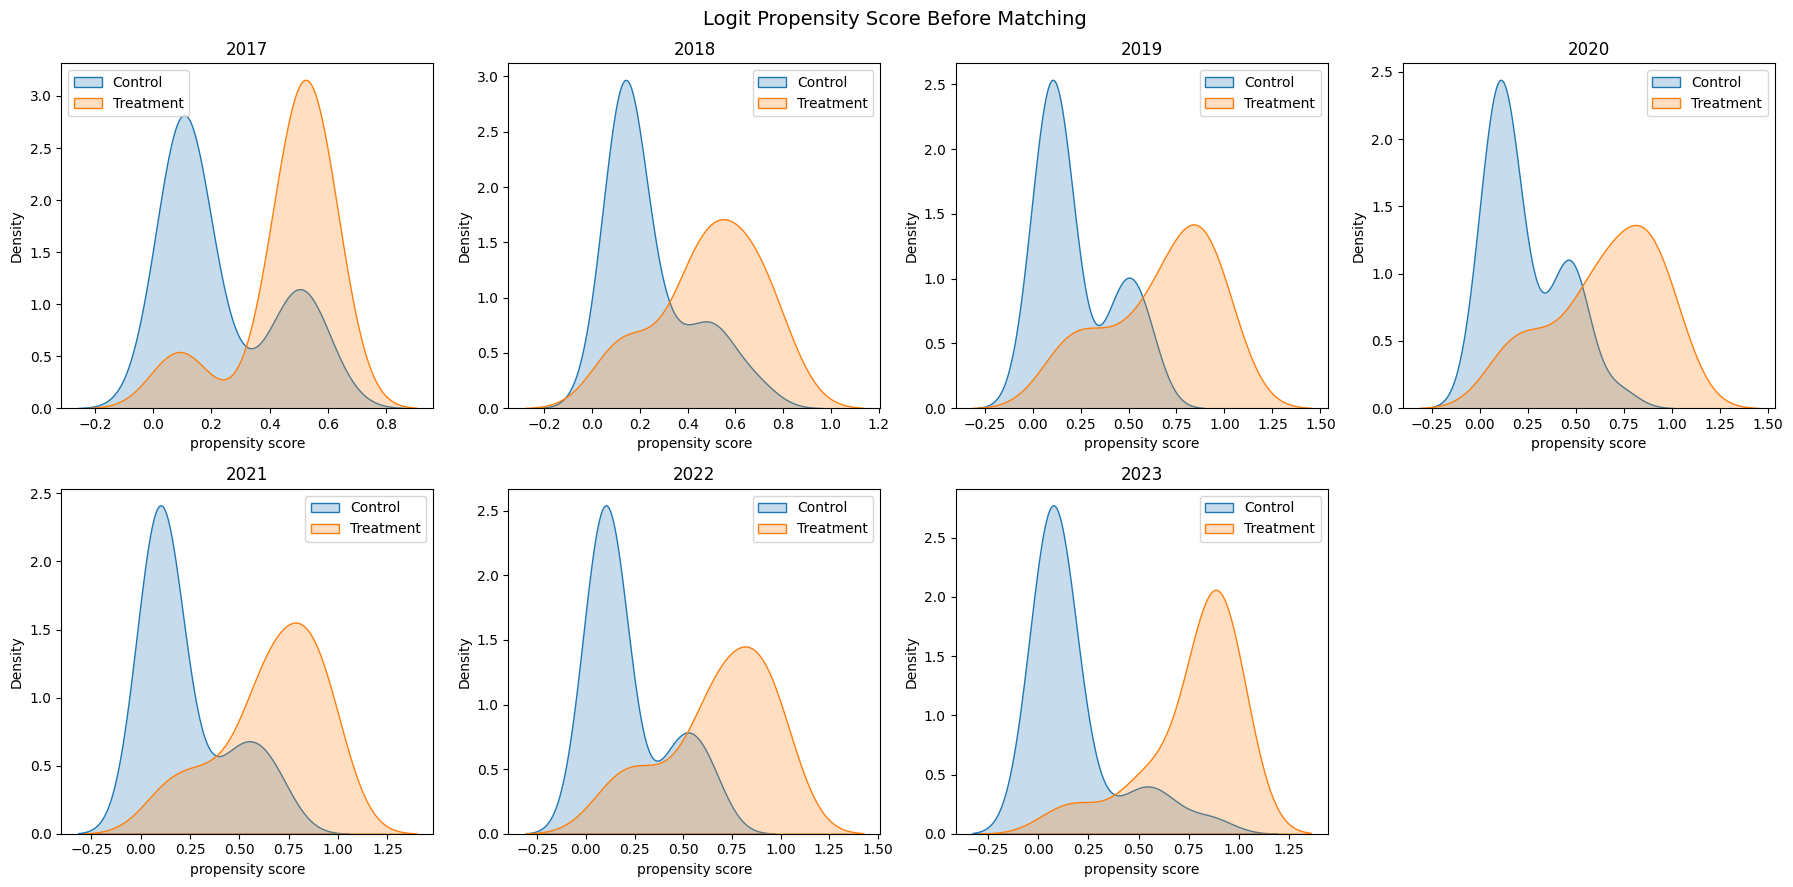

In [38]:
years = range(2017,2024)

fig, axes = plt.subplots(2,4,figsize=(18,9))
axes = axes.flatten()

for i, y in enumerate(years):
  sns.kdeplot(merged_df[merged_df[f"policy_{y}"]==0][f"propensity_{y}"], ax=axes[i],fill=True,label="Control")
  sns.kdeplot(merged_df[merged_df[f"policy_{y}"]==1][f"propensity_{y}"], ax=axes[i],fill=True,label="Treatment")
  axes[i].set_title(y)
  axes[i].set_xlabel("propensity score")
  axes[i].legend()

fig.delaxes(axes[7])
fig.suptitle("Logit Propensity Score Before Matching",fontsize=14)
plt.tight_layout()
plt.show()

**[Observation]**
- The control and treatment groups show limited overlap, with the treatment group generally right skewed (higher score).
- These differences in confounders can bias simple comparisons, highlighting the need for propensity score matching to balance the distributions.
- Because of limited overlap, matching may be less effective for certain regions of the score distribution.

## 4.2. Propensity Score Matching: Nearest Neighbor
- Using NearestNeighbors, treated states were matched to the most similar control states based on propensity scores.
  - 1:2 nearest neighbor matching was applied, as the control group had more states than the treatment group.
  - A caliper of 0.2 * standard deviation (sd) of the propensity scores was implemented to avoid poor matches.


In [39]:
years = range(2017, 2024)
match_treat = {}
match_control = {}

for y in years:
  treat = merged_df[merged_df[f"policy_{y}"]==1]
  control = merged_df[merged_df[f"policy_{y}"]==0]

  k=2
  nn = NearestNeighbors(n_neighbors=k)
  nn.fit(control[[f"propensity_{y}"]])
  distance, index = nn.kneighbors(treat[[f"propensity_{y}"]])
  caliper = 0.2 * np.std(merged_df[f"propensity_{y}"])
  d_c = distance <= caliper

  match_t = []
  match_c = []
  for i, c in enumerate(d_c):
    for j in range(k):
      if c[j] == True:
        match_t.append(treat.iloc[i])
        match_c.append(control.iloc[index[i,j]])

  match_treat[y] = pd.DataFrame(match_t).reset_index(drop=True)
  match_control[y] = pd.DataFrame(match_c).reset_index(drop=True)

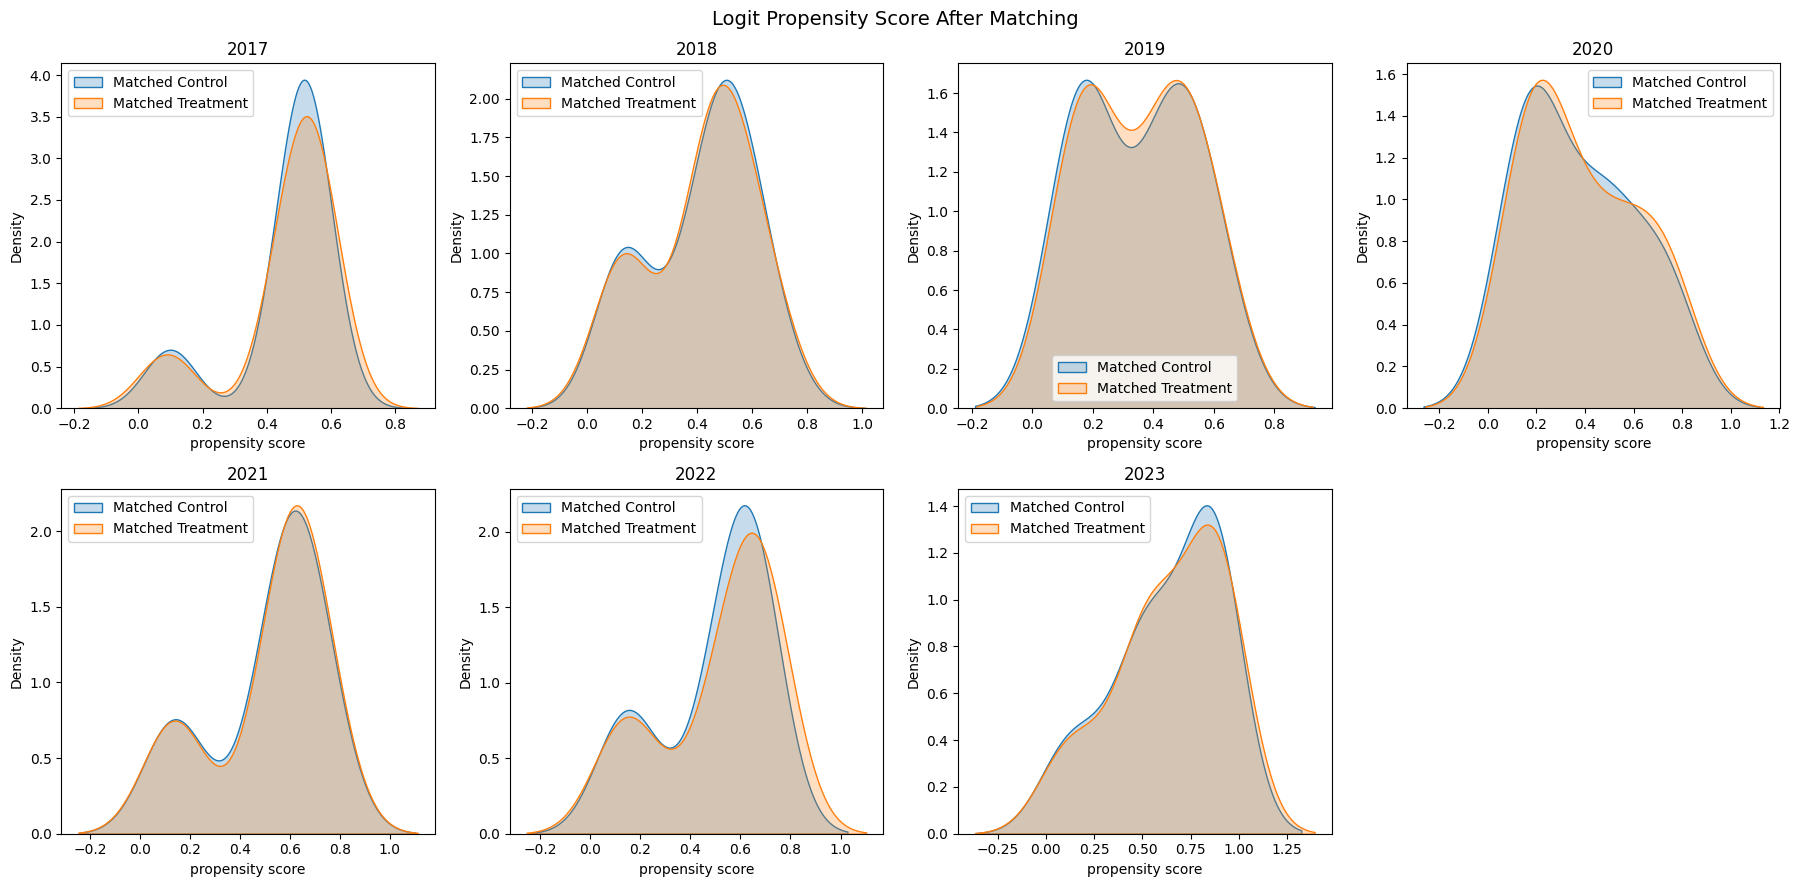

In [40]:
fig, axes = plt.subplots(2,4, figsize=(18,9))
axes = axes.flatten()

for i, y in enumerate(years):
  sns.kdeplot(match_control[y][f"propensity_{y}"], ax=axes[i],fill=True, label="Matched Control")
  sns.kdeplot(match_treat[y][f"propensity_{y}"], ax=axes[i],fill=True, label="Matched Treatment")
  axes[i].set_title(y)
  axes[i].set_xlabel("propensity score")
  axes[i].legend()

fig.delaxes(axes[7])
fig.suptitle("Logit Propensity Score After Matching", fontsize=14)
plt.tight_layout()
plt.show()

**[Observation]**
- After matching, the distribution of propensity scores for the two groups are much more similar compared to before matching.
- Some imbalance remains, meaning the groups are not perfectly balanced, but the similarity is sufficient to allow interpretation of the estimated policy effects.

# 5. Covariate Balance
- Used the Standardized Mean Difference (SMD) to assess covariate balance between the treated and control groups.


## 5.1. General Check for propensity Score Matching Balance: SMD
- $SMD = \frac{\bar{X}{treat} -\bar{X}{control}}{\sqrt{\frac{Var(X_{treat})+ Var(X_{control})}{2}}}$
  - SMD values close to 0 indicate good balance, while larger absolute values indicate imbalance.

In [41]:
def smd(treat, control, col):
  t_mean = treat[col].mean()
  c_mean = control[col].mean()
  std = np.sqrt((treat[col].var() + control[col].var()) / 2)
  return (t_mean - c_mean) / std

In [42]:
years = range(2017,2024)
for y in years:
  confounder = [f"co2_{y}",f"EV_Station_{y}", f"Political_{y}_Dem",f"Political_{y}_Rep",f"gdp_{y}"]
  print(f"{y}:")
  for col in confounder:
    before_smd = smd(merged_df[merged_df[f"policy_{y}"]==1],merged_df[merged_df[f"policy_{y}"]==0], col)
    after_smd = smd(match_treat[y], match_control[y],col)
    print(f"  {col}: SMD Before = {before_smd:.3f}, After = {after_smd:.3f}")

2017:
  co2_2017: SMD Before = -0.407, After = -0.110
  EV_Station_2017: SMD Before = 0.257, After = -0.045
  Political_2017_Dem: SMD Before = 0.475, After = -0.156
  Political_2017_Rep: SMD Before = -1.242, After = 0.000
  gdp_2017: SMD Before = 0.364, After = -0.053
2018:
  co2_2018: SMD Before = -0.399, After = 0.302
  EV_Station_2018: SMD Before = 0.246, After = -0.219
  Political_2018_Dem: SMD Before = 0.671, After = -0.119
  Political_2018_Rep: SMD Before = -1.110, After = 0.000
  gdp_2018: SMD Before = 0.276, After = -0.180
2019:
  co2_2019: SMD Before = -0.546, After = -0.261
  EV_Station_2019: SMD Before = 0.942, After = 0.065
  Political_2019_Dem: SMD Before = 1.070, After = -0.826
  Political_2019_Rep: SMD Before = -1.519, After = -0.177
  gdp_2019: SMD Before = 0.337, After = -0.023
2020:
  co2_2020: SMD Before = -0.559, After = 0.196
  EV_Station_2020: SMD Before = 0.969, After = -0.605
  Political_2020_Dem: SMD Before = 0.956, After = -0.611
  Political_2020_Rep: SMD Befo

**[SMD Results]**
- Covariate balance improved substantially after matching, with most confounders showing SMD less than 0.2 across years.
- Some variables in recent years remained imbalaned, likely due to limited overlap and skewed distributions.
- Overall, matching reduced bias and created more comparable treatment and control groups, but minor imbalance should still be considered when interpreting the results.


# 6. Causal Effect Estimation
Estimated the Average Treatment Effect on the Treated (ATT) and 95% Confidence Intervals to evaluate the causal effect of the policy.

## 6.1. Causal Effect: Average Treatement Effect on the Treated (ATT)
For each year, the ATT was calculated as the average difference in the outcome (EV growth) between each treated state and its matched control states.
- A Positive ATT means that states with EV supportive policies experienced a greater increase in EV registration growth per 10,000 people compared to similar states without such policies.

In [43]:
atts = []
for i, y in enumerate(years):
  att = (match_treat[y][f"EV_growth_{y}"] - match_control[y][f"EV_growth_{y}"]).mean()
  atts.append(att)
  print(f"Year {y} Estimated Average Treatment Effect on the Treated (ATT): {att:.2f} EVs")

Year 2017 Estimated Average Treatment Effect on the Treated (ATT): 0.68 EVs
Year 2018 Estimated Average Treatment Effect on the Treated (ATT): 1.39 EVs
Year 2019 Estimated Average Treatment Effect on the Treated (ATT): 0.18 EVs
Year 2020 Estimated Average Treatment Effect on the Treated (ATT): -0.60 EVs
Year 2021 Estimated Average Treatment Effect on the Treated (ATT): 4.94 EVs
Year 2022 Estimated Average Treatment Effect on the Treated (ATT): 7.56 EVs
Year 2023 Estimated Average Treatment Effect on the Treated (ATT): 12.28 EVs


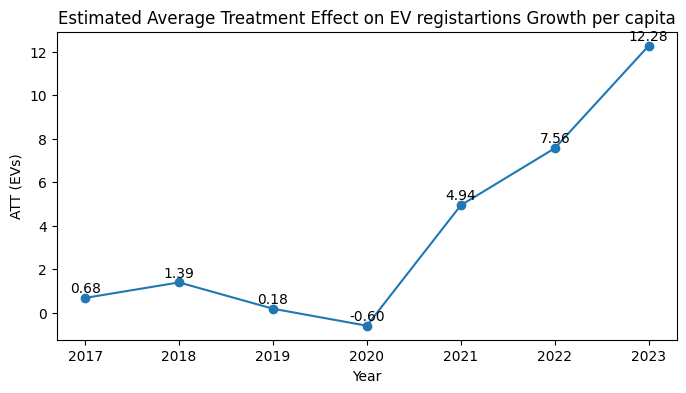

In [44]:
plt.figure(figsize=(8,4))
plt.plot(years, atts, marker="o")
for x, y in zip(years, atts):
    plt.text(x, y + 0.25, f"{y:.2f}", ha='center')
plt.title("Estimated Average Treatment Effect on EV registartions Growth per capita")
plt.xlabel("Year")
plt.ylabel("ATT (EVs)")
plt.show()

**[ATT Results]**
- ATT increased over time from 0.68 in 2017 to 12.28 in 2023, indicating that EV supportive policies generated additional gains beyond overall market growth.
- ATT was relatively small from 2017 to 2019 because many policy states had implemented policies before 2017, and the EV market began to grow rapidly starting in 2017 when the Tesla Model 3 became widely popular, expanding adoption beyond early adopters.
- In 2020, ATT became negative, likely due to the initial disruption caused by the COVID-19 pandemic.
- From 2021 to 2023, ATT increased substantially, indicating that the gap in EV registration growth between states with and without policies widened significantly.



## 6.2. Confidence Interval based on ATT
The confidence intervals were calculated by bootstraping the ATT for a given year, repeatedly resampling the matched treated and control states with replacement and computing the mean difference in EV registration growth.
- If the confidence interval includes 0, the effect is statistically insignificant.

In [45]:
def bootstrap_att(treat, control, n_bootstrap=1000, year=2016):
  np.random.seed(42)
  atts = []
  for i in range(n_bootstrap):
    sample_treat = treat.sample(len(treat), replace=True)
    sample_control = control.sample(len(control), replace=True)
    att = (sample_treat[f"EV_growth_{year}"].values - sample_control[f"EV_growth_{year}"].values).mean()
    atts.append(att)
  return np.array(atts)

In [46]:
years = range(2017,2024)
lower_list = []
upper_list = []
mean_list = []
for y in years:
  print(f"{y}:")
  bootstrap = bootstrap_att(match_treat[y], match_control[y],n_bootstrap=1000, year = y)
  lower, upper = np.percentile(bootstrap, [2.5, 97.5])
  mean_att = bootstrap.mean()
  mean_list.append(mean_att)
  lower_list.append(lower)
  upper_list.append(upper)
  print(f"  Bootstrap ATT = {mean_att:.2f}")
  print(f"  95% CI = [{lower:.2f}, {upper:.2f}]")

2017:
  Bootstrap ATT = 0.66
  95% CI = [-0.79, 2.11]
2018:
  Bootstrap ATT = 1.36
  95% CI = [-0.48, 3.48]
2019:
  Bootstrap ATT = 0.21
  95% CI = [-1.73, 2.36]
2020:
  Bootstrap ATT = -0.59
  95% CI = [-2.67, 1.80]
2021:
  Bootstrap ATT = 4.95
  95% CI = [2.17, 7.77]
2022:
  Bootstrap ATT = 7.64
  95% CI = [2.44, 12.88]
2023:
  Bootstrap ATT = 12.32
  95% CI = [5.28, 20.00]


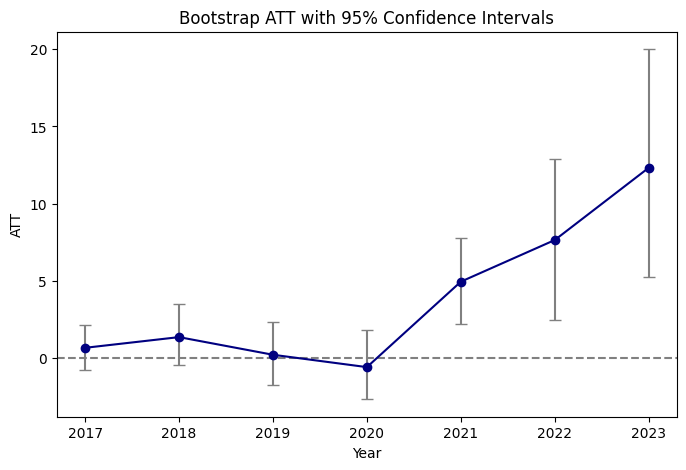

In [48]:
plt.figure(figsize=(8,5))
plt.errorbar(years, mean_list, yerr=[[m-l for l,m in zip(lower_list, mean_list)], [u-m for u,m in zip(upper_list, mean_list)]], color="navy",
             fmt="o-",capsize=4,ecolor = "grey")
plt.axhline(color = 'grey', linestyle="--")
plt.title("Bootstrap ATT with 95% Confidence Intervals")
plt.ylabel("ATT")
plt.xlabel("Year")
plt.show()

**[CI Interpretation]**
- From 2017 to 2019, ATT estimates were samll and statistically insignificant, as the 95% confidence intervals included 0.
- In 2020, ATT became negative and remained statistically insignificant, likely due to COVID-19 related market disruption.
- After 2020, the 95% confidence intervals no longer included 0, indicating a statistically significant positive impact of EV supportive policies.
- Although the CI are widened overtime, indicating increased variablility in the estimates, the policy effect remained statistically significant.



# 7. Propensity Score: Conclusion
The implementation of EV supportive policies causally increased EV registrations in U.S. states.
- Particularly after 2020, propensity score matching results show a clear and increasing positive Average Treatment Effect on the Treated (ATT), indicating that states with EV supportive policies experienced significantly higher light duty EV registration growth compared to similar states without such policies.
- In addition, confidence intervals after 2020 no longer included 0, indicating that the effect is statistically significant and reflects a true causal impact rather than random variation.